In [ ]:
import os
os.environ['KAGGLE_USERNAME']="mohameddany"
os.environ['KAGGLE_Key']="179b1b409a9994b74b3b6351cbd6c7a4"
!kaggle datasets download -d mateuszbuda/lgg-mri-segmentation

 99% 704M/714M [00:04<00:00, 180MB/s]
100% 714M/714M [00:04<00:00, 177MB/s]


In [ ]:
from zipfile import ZipFile

file_name="/content/lgg-mri-segmentation.zip"

with ZipFile(file_name, 'r') as ziip:
  ziip.extractall()
  print('woow')

woow


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import cv2
from skimage import io
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import *
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import tensorflow.keras.backend as K
from keras.losses import binary_crossentropy
import random
from sklearn.preprocessing import StandardScaler, normalize
from IPython.display import display
import PIL
%matplotlib inline
from glob import glob
from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, AveragePooling2D, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from keras.models import save_model
from keras.models import model_from_json
from keras.models import model_from_json
from sklearn.model_selection import train_test_split
from keras.losses import binary_crossentropy
import keras


In [ ]:
train_files = []
#
mask_files = glob('/content/lgg-mri-segmentation/kaggle_3m/*/*_mask*')

for i in mask_files:
    train_files.append(i.replace('_mask', ''))

In [ ]:
df = pd.DataFrame({"image_path": train_files, "mask_path":mask_files})

def diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))
    if value:
        return 1
    else:
        return 0

df['mask'] = df["mask_path"].apply(lambda x: diagnosis(x))

In [ ]:
df.head()

image_path  ... mask
0  /content/lgg-mri-segmentation/kaggle_3m/TCGA_H...  ...    0
1  /content/lgg-mri-segmentation/kaggle_3m/TCGA_H...  ...    0
2  /content/lgg-mri-segmentation/kaggle_3m/TCGA_H...  ...    0
3  /content/lgg-mri-segmentation/kaggle_3m/TCGA_H...  ...    0
4  /content/lgg-mri-segmentation/kaggle_3m/TCGA_H...  ...    0

[5 rows x 3 columns]

In [ ]:
df['mask'].value_counts()          #We have 1373 record


0    2556
1    1373
Name: mask, dtype: int64

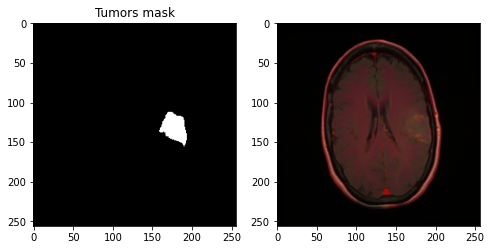

In [ ]:
for i in range(len(df)):
    if cv2.imread(df.mask_path[i]).max() > 0:
        break

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.imshow(cv2.imread(df.mask_path[i]));
plt.title('Tumors mask')

plt.subplot(1,2,2)
plt.imshow(cv2.imread(df.image_path[i]));

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3929 non-null   object
 1   mask_path   3929 non-null   object
 2   mask        3929 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 92.2+ KB


In [ ]:
brain_df_train = df
brain_df_train['mask'] = brain_df_train['mask'].apply(lambda x: str(x))
brain_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3929 non-null   object
 1   mask_path   3929 non-null   object
 2   mask        3929 non-null   object
dtypes: object(3)
memory usage: 92.2+ KB


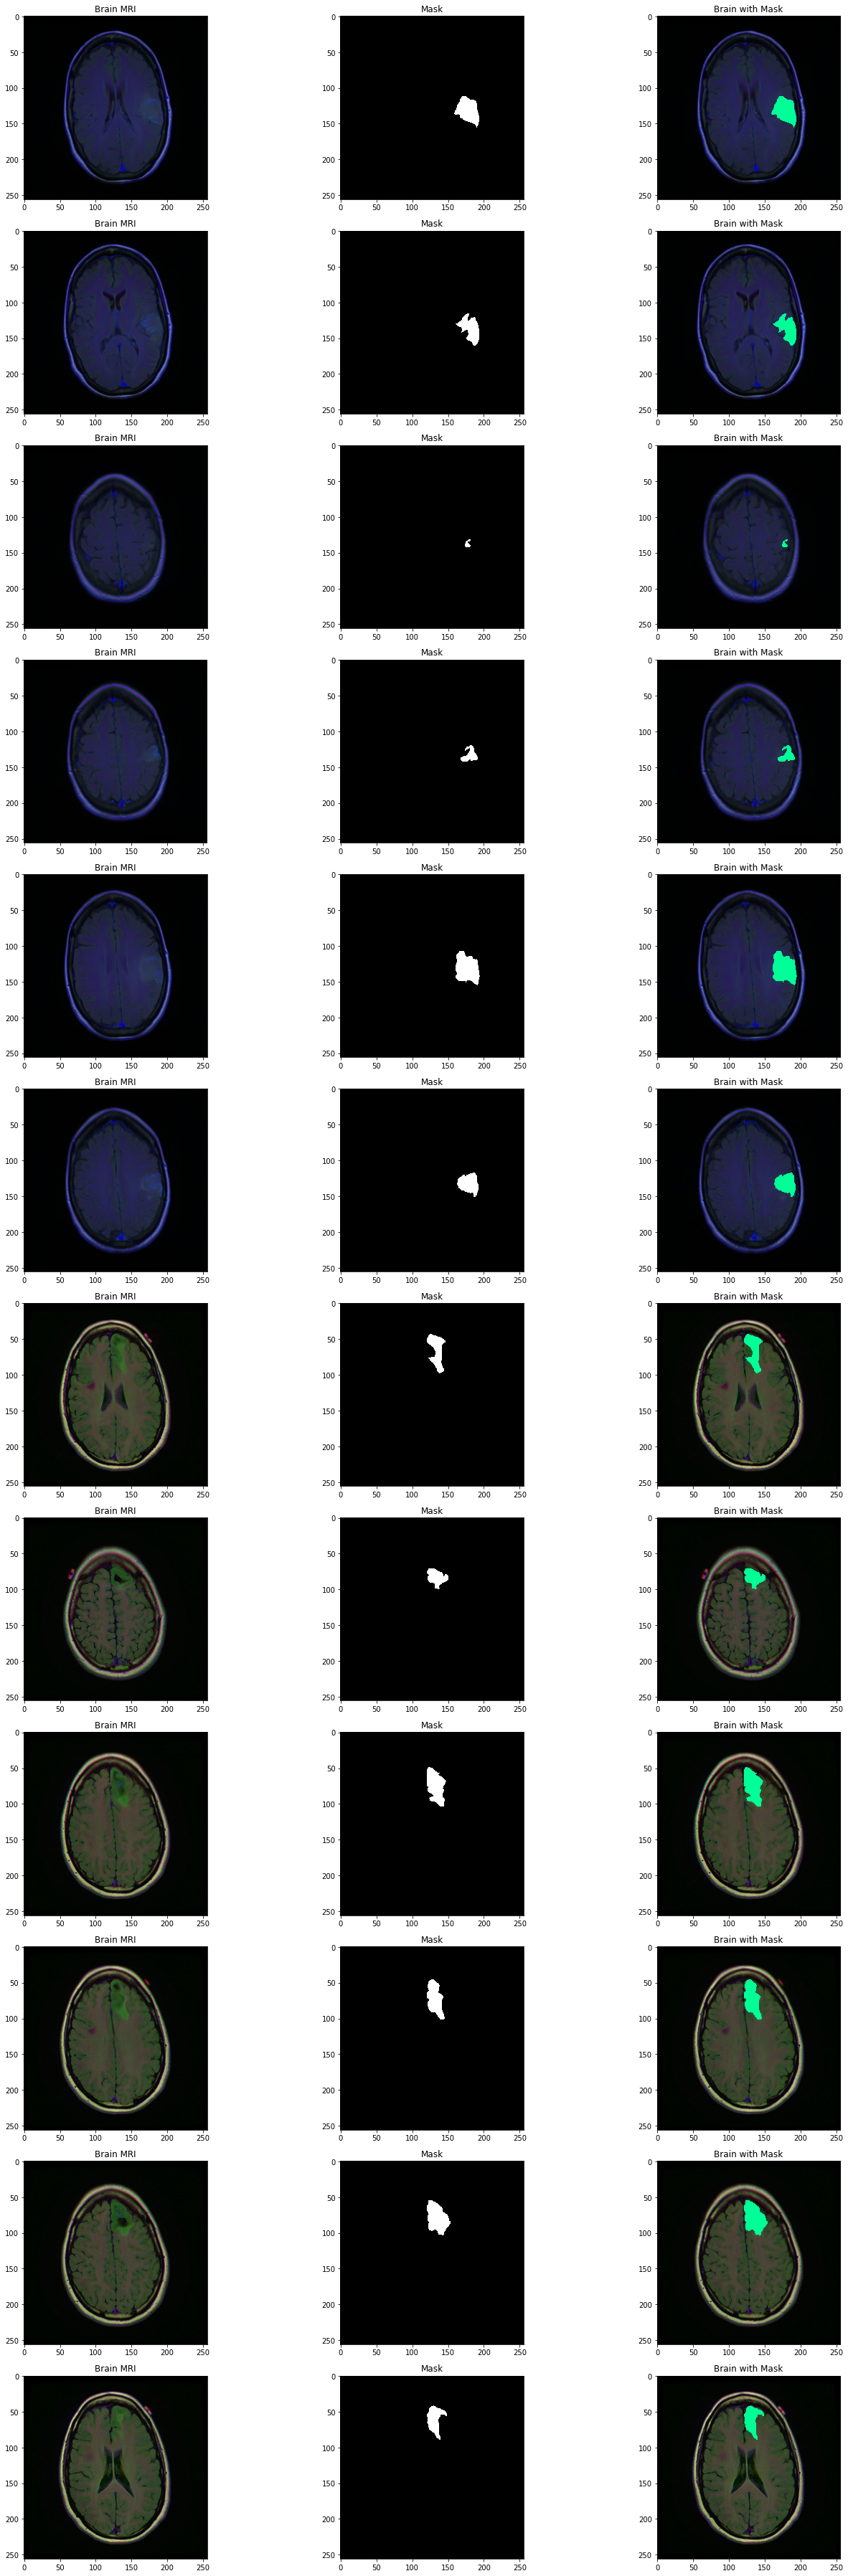

In [ ]:
count = 0
i = 0
Figure,xs = plt.subplots(12,3, figsize=(20,50))
for mask in df['mask']:
    if (mask=="1"):
        img = io.imread(df.image_path[i])
        xs[count][0].title.set_text("Brain MRI")
        xs[count][0].imshow(img)
        
        mask = io.imread(df.mask_path[i])
        xs[count][1].title.set_text("Mask")
        xs[count][1].imshow(mask, cmap='gray')
        
        img[mask==255] = (0,255,150)  # change pixel color at the position of mask
        xs[count][2].title.set_text("Brain with Mask")
        xs[count][2].imshow(img)
        count +=1
    i += 1
    if (count==12):
        break
        
Figure.tight_layout()


In [ ]:
brain_df_mask = df[df['mask'] == "1"]
 
brain_df_mask

image_path  ... mask
6     /content/lgg-mri-segmentation/kaggle_3m/TCGA_H...  ...    1
8     /content/lgg-mri-segmentation/kaggle_3m/TCGA_H...  ...    1
11    /content/lgg-mri-segmentation/kaggle_3m/TCGA_H...  ...    1
14    /content/lgg-mri-segmentation/kaggle_3m/TCGA_H...  ...    1
18    /content/lgg-mri-segmentation/kaggle_3m/TCGA_H...  ...    1
...                                                 ...  ...  ...
3893  /content/lgg-mri-segmentation/kaggle_3m/TCGA_D...  ...    1
3903  /content/lgg-mri-segmentation/kaggle_3m/TCGA_D...  ...    1
3908  /content/lgg-mri-segmentation/kaggle_3m/TCGA_D...  ...    1
3915  /content/lgg-mri-segmentation/kaggle_3m/TCGA_D...  ...    1
3928  /content/lgg-mri-segmentation/kaggle_3m/TCGA_D...  ...    1

[1373 rows x 3 columns]

In [ ]:
X_train, X_val = train_test_split(brain_df_mask, test_size=0.15)
X_test, X_val = train_test_split(X_val, test_size=0.5)
print("Train size is {}, valid size is {} & test size is {}".format(len(X_train), len(X_val), len(X_test)))

train_ids = list(X_train.image_path)
train_mask = list(X_train.mask_path)

val_ids = list(X_val.image_path)
val_mask= list(X_val.mask_path)

Train size is 1167, valid size is 103 & test size is 103


In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
  def __init__(self, ids , mask, image_dir = './', batch_size = 16, img_h = 256, img_w = 256, shuffle = True):
    self.ids = ids
    self.mask = mask
    self.image_dir = image_dir
    self.batch_size = batch_size
    self.img_h = img_h
    self.img_w = img_w
    self.shuffle = shuffle
    self.on_epoch_end()
  def __len__(self):
    return int(np.floor(len(self.ids)) / self.batch_size)

  def __getitem__(self, index):
    indexes = self.indexes[index* self.batch_size : (index+1) * self.batch_size]
    list_ids = [self.ids[i] for i in indexes]
    list_mask = [self.mask[i] for i in indexes]
    X, y = self.__data_generation(list_ids, list_mask)
    return X, y

  def on_epoch_end(self):    
    self.indexes = np.arange(len(self.ids))

    if self.shuffle:
      np.random.shuffle(self.indexes)

  def __data_generation(self, list_ids, list_mask):

    X = np.empty((self.batch_size, self.img_h, self.img_w, 3))
    y = np.empty((self.batch_size, self.img_h, self.img_w, 1))

    for i in range(len(list_ids)):
      img_path = str(list_ids[i])
      mask_path = str(list_mask[i])
      img = io.imread(img_path)
      mask = io.imread(mask_path)
      img = cv2.resize(img,(self.img_h,self.img_w))
      img = np.array(img, dtype = np.float64)
      mask = cv2.resize(mask,(self.img_h,self.img_w))
      mask = np.array(mask, dtype = np.float64)
      img -= img.mean()
      img /= img.std()
      mask -= mask.mean()
      mask /= mask.std()
      X[i,] = img
      y[i,] = np.expand_dims(mask, axis = 2)
    y = (y > 0).astype(int)
    return X, y

train_data = DataGenerator(train_ids, train_mask)
val_data = DataGenerator(val_ids, val_mask)

In [ ]:
def dice_coef(y_true, y_pred):
    y_pred = tf.cast(y_pred, tf.float32)
    y_true = tf.cast(y_true, tf.float32)
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (
                    K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

In [ ]:
def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [ ]:
def tversky(ytrue, ypred):
    ypredpos = K.flatten(ypred)
    ytruepos = K.flatten(ytrue)
    truepos = K.sum(ytruepos * ypredpos)
    falseneg = K.sum(ytruepos * (1-ypredpos))
    falsepos = K.sum((1-ytruepos)*ypredpos)
    alpha = 0.7
    smooth=100
    return (truepos + smooth)/(truepos + alpha*falseneg + (1-alpha)*falsepos + smooth)

def focaltversky(ytrue,ypred):
    ypred = tf.cast(ypred, tf.float32)
    ytrue = tf.cast(ytrue, tf.float32)
    
    pt_1 = tversky(ytrue, ypred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)

def tversky_loss(ytrue, ypred):
    return 1 - tversky(ytrue,ypred)

**Segnet model**

In [ ]:
# Encoding layer
img_input = Input(shape= (256, 256, 3))
x = Conv2D(64, (3, 3), padding='same', name='conv1',strides= (1,1))(img_input)
x = BatchNormalization(name='bn1')(x)
x = Activation('relu')(x)
x = Conv2D(64, (3, 3), padding='same', name='conv2')(x)
x = BatchNormalization(name='bn2')(x)
x = Activation('relu')(x)
x = MaxPooling2D()(x)

x = Conv2D(128, (3, 3), padding='same', name='conv3')(x)
x = BatchNormalization(name='bn3')(x)
x = Activation('relu')(x)
x = Conv2D(128, (3, 3), padding='same', name='conv4')(x)
x = BatchNormalization(name='bn4')(x)
x = Activation('relu')(x)
x = MaxPooling2D()(x)

x = Conv2D(256, (3, 3), padding='same', name='conv5')(x)
x = BatchNormalization(name='bn5')(x)
x = Activation('relu')(x)
x = Conv2D(256, (3, 3), padding='same', name='conv6')(x)
x = BatchNormalization(name='bn6')(x)
x = Activation('relu')(x)
x = Conv2D(256, (3, 3), padding='same', name='conv7')(x)
x = BatchNormalization(name='bn7')(x)
x = Activation('relu')(x)
x = MaxPooling2D()(x)

x = Conv2D(512, (3, 3), padding='same', name='conv8')(x)
x = BatchNormalization(name='bn8')(x)
x = Activation('relu')(x)
x = Conv2D(512, (3, 3), padding='same', name='conv9')(x)
x = BatchNormalization(name='bn9')(x)
x = Activation('relu')(x)
x = Conv2D(512, (3, 3), padding='same', name='conv10')(x)
x = BatchNormalization(name='bn10')(x)
x = Activation('relu')(x)
x = MaxPooling2D()(x)

x = Conv2D(512, (3, 3), padding='same', name='conv11')(x)
x = BatchNormalization(name='bn11')(x)
x = Activation('relu')(x)
x = Conv2D(512, (3, 3), padding='same', name='conv12')(x)
x = BatchNormalization(name='bn12')(x)
x = Activation('relu')(x)
x = Conv2D(512, (3, 3), padding='same', name='conv13')(x)
x = BatchNormalization(name='bn13')(x)
x = Activation('relu')(x)
x = MaxPooling2D()(x)
###############################
x = Conv2D(1024, (3, 3), padding='same', name='conv14')(x)
x = BatchNormalization(name='bn14')(x)
x = Activation('relu')(x)
x = Conv2D(1024, (3, 3), padding='same', name='conv15')(x)
x = BatchNormalization(name='bn15')(x)
x = Activation('relu')(x)
x = Conv2D(1024, (3, 3), padding='same', name='conv16')(x)
x = BatchNormalization(name='bn16')(x)
x = Activation('relu')(x)
x = MaxPooling2D()(x)

x = Dense(2048, activation = 'relu', name='fc1')(x)
x = Dense(2048, activation = 'relu', name='fc2')(x)

# Decoding Layer 
x = UpSampling2D()(x)
x = Conv2DTranspose(1024, (3, 3), padding='same', name='deconv1')(x)
x = BatchNormalization(name='bn17')(x)
x = Activation('relu')(x)
x = Conv2DTranspose(1024, (3, 3), padding='same', name='deconv2')(x)
x = BatchNormalization(name='bn18')(x)
x = Activation('relu')(x)
x = Conv2DTranspose(1024, (3, 3), padding='same', name='deconv3')(x)
x = BatchNormalization(name='bn19')(x)
x = Activation('relu')(x)

####################################
x = UpSampling2D()(x)
x = Conv2DTranspose(1024, (3, 3), padding='same', name='deconv4')(x)
x = BatchNormalization(name='bn20')(x)
x = Activation('relu')(x)
x = Conv2DTranspose(1024, (3, 3), padding='same', name='deconv5')(x)
x = BatchNormalization(name='bn21')(x)
x = Activation('relu')(x)
x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv6')(x)
x = BatchNormalization(name='bn22')(x)
x = Activation('relu')(x)

x = UpSampling2D()(x)
x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv7')(x)
x = BatchNormalization(name='bn23')(x)
x = Activation('relu')(x)
x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv8')(x)
x = BatchNormalization(name='bn24')(x)
x = Activation('relu')(x)
x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv9')(x)
x = BatchNormalization(name='bn25')(x)
x = Activation('relu')(x)

x = UpSampling2D()(x)
x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv10')(x)
x = BatchNormalization(name='bn26')(x)
x = Activation('relu')(x)
x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv11')(x)
x = BatchNormalization(name='bn27')(x)
x = Activation('relu')(x)
x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv12')(x)
x = BatchNormalization(name='bn28')(x)
x = Activation('relu')(x)

x = UpSampling2D()(x)
x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv13')(x)
x = BatchNormalization(name='bn29')(x)
x = Activation('relu')(x)
x = Conv2DTranspose(64, (3, 3), padding='same', name='deconv14')(x)
x = BatchNormalization(name='bn30')(x)
x = Activation('relu')(x)

x = UpSampling2D()(x)
x = Conv2DTranspose(64, (3, 3), padding='same', name='deconv15')(x)
x = BatchNormalization(name='bn31')(x)
x = Activation('relu')(x)
x = Conv2DTranspose(1, (3, 3), padding='same', name='deconv16')(x)
x = BatchNormalization(name='bn32')(x)
x = Activation('sigmoid')(x)
pred = Reshape((256,256))(x)

In [ ]:
segnet_model=Model(inputs=img_input, outputs=pred)
adam = tf.keras.optimizers.Adam(lr = 0.01, epsilon = 0.1)

segnet_model.compile(optimizer= adam, loss= dice_coef_loss
                  , metrics=[tversky,dice_coef])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
segnet_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 256, 256, 64)      1792      
                                                                 
 bn1 (BatchNormalization)    (None, 256, 256, 64)      256       
                                                                 
 activation (Activation)     (None, 256, 256, 64)      0         
                                                                 
 conv2 (Conv2D)              (None, 256, 256, 64)      36928     
                                                                 
 bn2 (BatchNormalization)    (None, 256, 256, 64)      256       
                                                                 
 activation_1 (Activation)   (None, 256, 256, 64)      0     

In [ ]:
# !gdown --id 1-0pwkwmqSo8mDPIQUxXwVwQ4JWjhCNOw

Downloading...
From: https://drive.google.com/uc?id=1-0pwkwmqSo8mDPIQUxXwVwQ4JWjhCNOw
To: /content/history.csv
100% 12.2k/12.2k [00:00<00:00, 16.0MB/s]


In [ ]:
# history=pd.read_csv('/content/history.csv')

In [ ]:
# history.columns.values

array(['epoch', 'loss', 'lr', 'tversky', 'val_loss', 'val_tversky'],
      dtype=object)

In [ ]:

# plt.figure(figsize=(12,5))
# plt.subplot(1,2,1)
# plt.plot(history['loss']);
# plt.plot(history['val_loss']);
# plt.title("SEG Model   Loss");
# plt.ylabel("focal  loss");
# plt.xlabel("Epochs");
# plt.legend(['train', 'val']);

# plt.subplot(1,2,2)
# plt.plot(history['tversky']);
# plt.plot(history['val_tversky']);
# plt.title("SEG Model dice score");
# plt.ylabel("dice Accuracy");
# plt.xlabel("Epochs");
# plt.legend(['train', 'val']);

In [ ]:
test_ids = list(X_test.image_path)
test_mask = list(X_test.mask_path)
test_data = DataGenerator(test_ids, test_mask)
loss,dice_coef, tv = segnet_model.evaluate(test_data)
print("Segnet segmentation tversky is {:.2f}%".format(tv*100))

6/6 [==============================] - 194s 32s/step - loss: -0.9160 - tversky: 0.9257 - dice_coef: 0.9160
Segnet segmentation tversky is 91.60%


In [ ]:
print("Segnet segmentation dice_coef is {:.2f}%".format(dice_coef*100))

Segnet segmentation dice_coef is 92.57%


**UNet model**

In [ ]:
def conv_layer(X, f):
 
    Xcopy = X  
    X = Conv2D(f, kernel_size=(1,1), kernel_initializer='he_normal')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    
    X = Conv2D(f, kernel_size=(3,3), padding='same', kernel_initializer='he_normal')(X)
    X = BatchNormalization()(X)
    
    # Adding the output from main path and short path together
    X = Activation('relu')(X)
    
    return X

def upsample_concat(x, skip):
    '''
    funtion for upsampling image
    '''
    X = UpSampling2D((2,2))(x)
    merge = Concatenate()([X, skip])
    
    return merge

In [ ]:
inputshape = (256,256,3)
Xinput = Input(inputshape)

conv_1 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(Xinput)
conv_1 = BatchNormalization()(conv_1)
conv_1 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv_1)
conv_1 = BatchNormalization()(conv_1)
pool_1 = MaxPool2D((2,2))(conv_1)


conv_2 = conv_layer(pool_1, 32)
pool_2 = MaxPool2D((2,2))(conv_2)


conv_3 = conv_layer(pool_2, 64)
pool_3 = MaxPool2D((2,2))(conv_3)


conv_4 = conv_layer(pool_3, 128)
pool_4 = MaxPool2D((2,2))(conv_4)


conv_5 = conv_layer(pool_4, 256)


up_1 = upsample_concat(conv_5, conv_4)
up_1 = conv_layer(up_1, 128)


up_2 = upsample_concat(up_1, conv_3)
up_2 = conv_layer(up_2, 64)


up_3 = upsample_concat(up_2, conv_2)
up_3 = conv_layer(up_3, 32)


up_4 = upsample_concat(up_3, conv_1)
up_4 = conv_layer(up_4, 16)


out = Conv2D(1, (1,1), kernel_initializer='he_normal', padding='same', activation='sigmoid')(up_4)




In [ ]:
def dice_coef(y_true, y_pred):
    y_pred = tf.cast(y_pred, tf.float32)              #Due to a technical issue , the dice_coef function has to be re-ran before the next testing.
    y_true = tf.cast(y_true, tf.float32)
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (
                    K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

In [ ]:
UNet_model = Model(Xinput, out)
UNet_model.compile(optimizer = adam, 
                  loss = focaltversky, 
                  metrics = [tversky,dice_coef]
                 )

In [ ]:
UNet_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_2 (Conv2D)              (None, 256, 256, 16  448         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_2 (BatchNo  (None, 256, 256, 16  64         ['conv2d_2[0][0]']               
 rmalization)                   )                                                           

In [ ]:
_, tv,dice = UNet_model.evaluate(test_data)
print("UNet Segmentation tversky is {:.2f}%".format(tv*100))

6/6 [==============================] - 10s 2s/step - loss: 0.0910 - tversky: 0.9590 - dice_coef: 0.9487
UNet Segmentation tversky is 95.90%


In [ ]:
print("UNet Segmentation dice coef. is {:.2f}%".format(dice*100))

UNet Segmentation dice coef. is 94.87%


**Res-U-Net model**

In [ ]:
def resblock(X, f):
 
    Xcopy = X  
    
    # main path
    X = Conv2D(f, kernel_size=(1,1), kernel_initializer='he_normal')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    
    X = Conv2D(f, kernel_size=(3,3), padding='same', kernel_initializer='he_normal')(X)
    X = BatchNormalization()(X)
    
    # shortcut path
    Xcopy = Conv2D(f, kernel_size=(1,1), kernel_initializer='he_normal')(Xcopy)
    Xcopy = BatchNormalization()(Xcopy)
    
    # Adding the output from main path and short path together
    X = Add()([X, Xcopy])
    X = Activation('relu')(X)
    
    return X

def upsample_concat(x, skip):
    '''
    funtion for upsampling image
    '''
    X = UpSampling2D((2,2))(x)
    merge = Concatenate()([X, skip])
    
    return merge

In [ ]:
inputshape = (256,256,3)
Xinput = Input(inputshape)

conv_1 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(Xinput)
conv_1 = BatchNormalization()(conv_1)
conv_1 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv_1)
conv_1 = BatchNormalization()(conv_1)
pool_1 = MaxPool2D((2,2))(conv_1)


conv_2 = resblock(pool_1, 32)
pool_2 = MaxPool2D((2,2))(conv_2)


conv_3 = resblock(pool_2, 64)
pool_3 = MaxPool2D((2,2))(conv_3)


conv_4 = resblock(pool_3, 128)
pool_4 = MaxPool2D((2,2))(conv_4)


conv_5 = resblock(pool_4, 256)


up_1 = upsample_concat(conv_5, conv_4)
up_1 = resblock(up_1, 128)


up_2 = upsample_concat(up_1, conv_3)
up_2 = resblock(up_2, 64)


up_3 = upsample_concat(up_2, conv_2)
up_3 = resblock(up_3, 32)


up_4 = upsample_concat(up_3, conv_1)
up_4 = resblock(up_4, 16)


out = Conv2D(1, (1,1), kernel_initializer='he_normal', padding='same', activation='sigmoid')(up_4)



In [ ]:
Res_Unet_model=Model(Xinput, out)

Res_Unet_model.compile(optimizer = adam, 
                  loss = focaltversky, 
                  metrics = [tversky]
                 )

In [ ]:
Res_Unet_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_21 (Conv2D)             (None, 256, 256, 16  448         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_20 (BatchN  (None, 256, 256, 16  64         ['conv2d_21[0][0]']              
 ormalization)                  )                                                           

In [ ]:
_, tv= Res_Unet_model.evaluate(test_data)
print("Segmentation tversky is {:.2f}%".format(tv*100))

6/6 [==============================] - 11s 2s/step - loss: 0.0701 - tversky: 0.9710
Segmentation tversky is 97.10%


In [ ]:
Res_Unet_model=Model(Xinput, out) #Due to technical issues the Res-U-Net has to be recompiled with the dice coef. metric

Res_Unet_model.compile(optimizer = adam, 
                  loss = focaltversky, 
                  metrics = [dice_coef]
                 )

In [ ]:
Res_Unet_model.load_weights("/content/ResUnet-seg-model.h5")
_, dice= Res_Unet_model.evaluate(test_data)
print("Segmentation dice coef. is {:.2f}%".format(dice*100))

6/6 [==============================] - 13s 2s/step - loss: 0.0741 - dice_coef: 0.9616
Segmentation dice coef. is 96.16%


In [ ]:
def prediction(test, model_seg):
    
    mask, image_id, mask_path =  [], [],[]
    
    for i in test.image_path:
        img = io.imread(i)        
        img = img *1./255.
        img = cv2.resize(img, (256,256))
        img = np.array(img, dtype=np.float64)
        img = np.reshape(img, (1,256,256,3))

        X = np.empty((1,256,256,3))
        
        img = io.imread(i)
        img = cv2.resize(img, (256,256))
        img = np.array(img, dtype=np.float64)
        
        img -= img.mean()
        img /= img.std()
        X[0,] = img
        
        predict = model_seg.predict(X)
        
        image_id.append(i)
        mask.append(predict)
    for i in test.mask_path:
        mask_path.append(i)

    return pd.DataFrame({'image_path': image_id,'predicted_mask': mask,'mask_path':mask_path})

In [ ]:
!gdown --id 1-0justbmPpbXJPZyrGsS9xzjstc6WDae

Downloading...
From: https://drive.google.com/uc?id=1-0justbmPpbXJPZyrGsS9xzjstc6WDae
To: /content/ResUnet-seg-model.h5
100% 5.06M/5.06M [00:00<00:00, 85.1MB/s]


In [ ]:
!gdown --id 1j-iFxht3bb9YW06pMfTcliKexdQE6m6z

Downloading...
From: https://drive.google.com/uc?id=1j-iFxht3bb9YW06pMfTcliKexdQE6m6z
To: /content/Unet-seg-model.h5
100% 4.55M/4.55M [00:00<00:00, 47.5MB/s]


In [ ]:
!gdown --id 1-9HiyeGfdU6cTLxk0K6cssrUOn77Qx_2

Access denied with the following error:

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1-9HiyeGfdU6cTLxk0K6cssrUOn77Qx_2 



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
UNet_model.load_weights("/content/Unet-seg-model.h5")

In [ ]:
# from keras.models import load_model
segnet_model.load_weights('/content/drive/MyDrive/SEGNET_7nyka/Seg_net_D.h5')

In [ ]:
Res_Unet_model.load_weights("/content/ResUnet-seg-model.h5")

In [ ]:
segnet_pred=prediction(X_test, segnet_model)
unet_pred=prediction(X_test, UNet_model)
res_unet_pred=prediction(X_test,Res_Unet_model)

In [ ]:
segnet_pred

image_path  ...                                          mask_path
0    /content/lgg-mri-segmentation/kaggle_3m/TCGA_F...  ...  /content/lgg-mri-segmentation/kaggle_3m/TCGA_F...
1    /content/lgg-mri-segmentation/kaggle_3m/TCGA_F...  ...  /content/lgg-mri-segmentation/kaggle_3m/TCGA_F...
2    /content/lgg-mri-segmentation/kaggle_3m/TCGA_D...  ...  /content/lgg-mri-segmentation/kaggle_3m/TCGA_D...
3    /content/lgg-mri-segmentation/kaggle_3m/TCGA_H...  ...  /content/lgg-mri-segmentation/kaggle_3m/TCGA_H...
4    /content/lgg-mri-segmentation/kaggle_3m/TCGA_H...  ...  /content/lgg-mri-segmentation/kaggle_3m/TCGA_H...
..                                                 ...  ...                                                ...
98   /content/lgg-mri-segmentation/kaggle_3m/TCGA_D...  ...  /content/lgg-mri-segmentation/kaggle_3m/TCGA_D...
99   /content/lgg-mri-segmentation/kaggle_3m/TCGA_D...  ...  /content/lgg-mri-segmentation/kaggle_3m/TCGA_D...
100  /content/lgg-mri-segmentation/kaggle_3m/TCGA_F...  ...  /content/lgg-mri-segmentation/kaggle_3m/TCGA_F...
101  /content/lgg-mri-segmentation/kaggle_3m/TCGA_F...  ...  /content/lgg-mri-segmentation/kaggle_3m/TCGA_F...
102  /content/lgg-mri-segmentation/kaggle_3m/TCGA_D...  ...  /content/lgg-mri-segmentation/kaggle_3m/TCGA_D...

[103 rows x 3 columns]

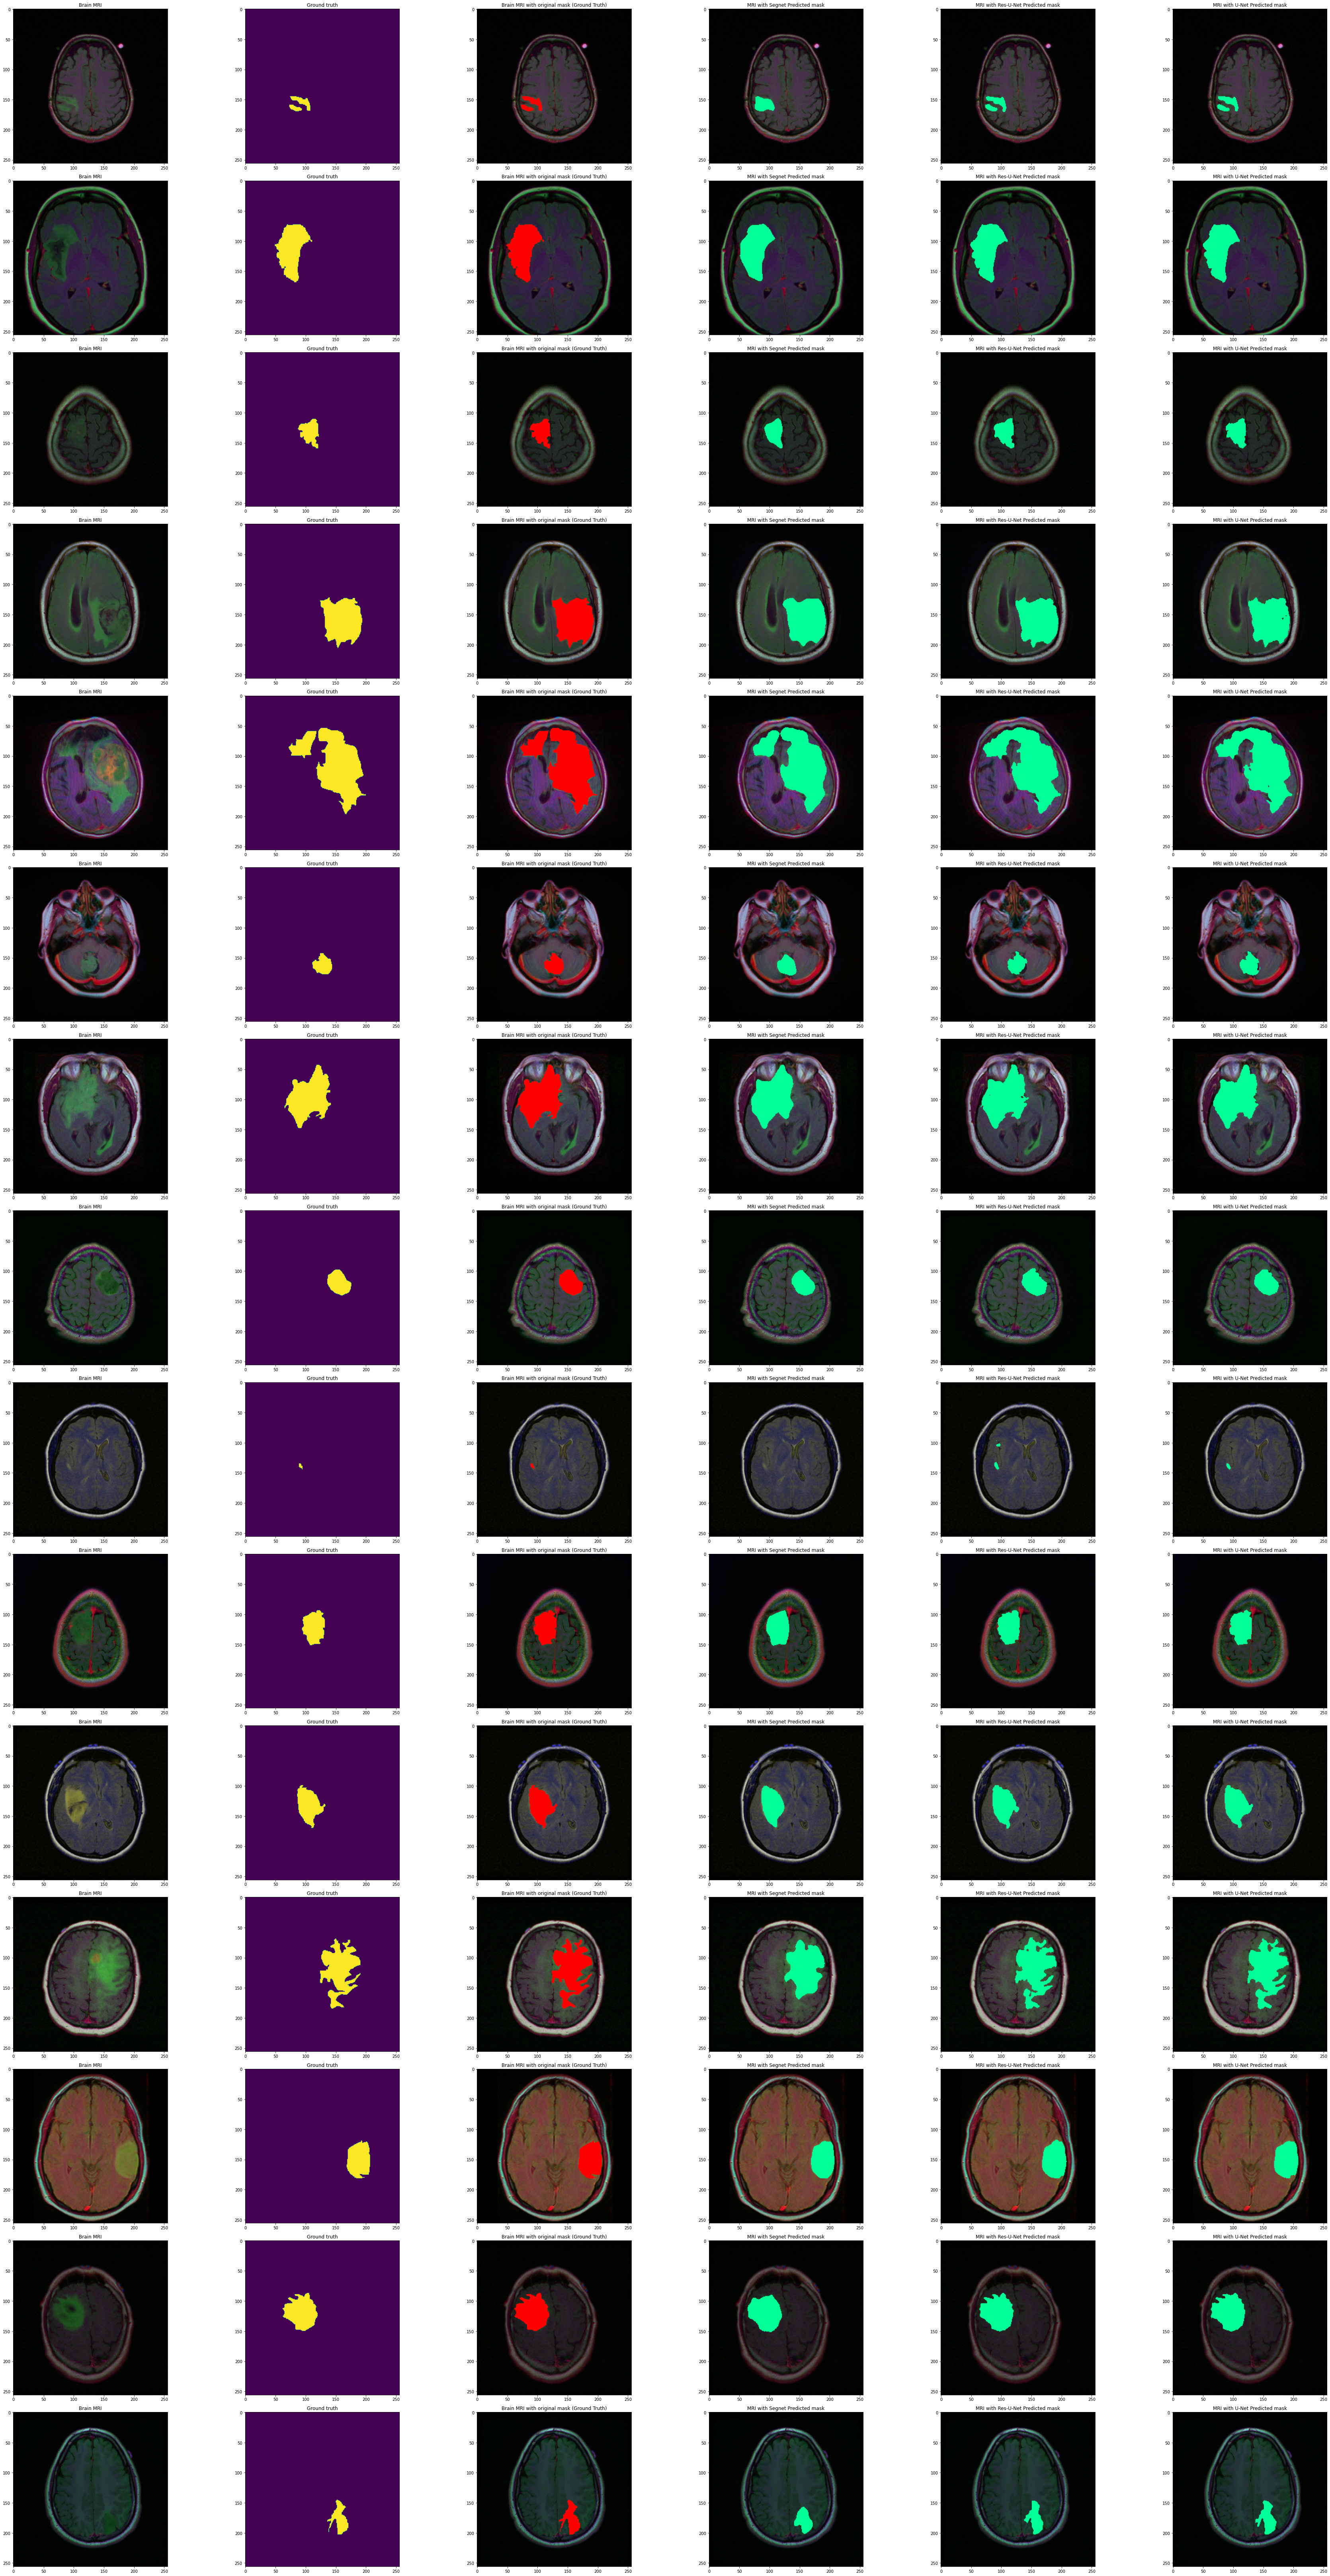

In [ ]:
count = 0
fig, axs = plt.subplots(15,6, figsize=(50,90))

for i in range(len(segnet_pred)):
    if  count<25:
        img = io.imread(segnet_pred.image_path[i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axs[count][0].imshow(img)
        axs[count][0].title.set_text('Brain MRI')
        
        mask = io.imread(segnet_pred.mask_path[i])
        axs[count][1].imshow(mask)
        axs[count][1].title.set_text('Ground truth')
        
        pred_seg = np.array(segnet_pred.predicted_mask[i]).squeeze().round()
        pred_res = np.array(res_unet_pred.predicted_mask[i]).squeeze().round()
        pred_unet = np.array(unet_pred.predicted_mask[i]).squeeze().round()
        # axs[count][2].imshow(pred)
        # axs[count][2].title.set_text('seg Predicted mask')

        # axs[count][3].imshow(pred_res)
        # axs[count][3].title.set_text('res Predicted mask')

        # axs[count][4].imshow(pred_unet)
        # axs[count][4].title.set_text('unet Predicted mask')
        
        img[mask==255] = (255,0,0)
        axs[count][2].imshow(img)
        axs[count][2].title.set_text('Brain MRI with original mask (Ground Truth)')
        
        img_ = io.imread(segnet_pred.image_path[i])
        img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
        img_[pred_seg==1] = (0,255,150)
        axs[count][3].imshow(img_)
        axs[count][3].title.set_text('MRI with Segnet Predicted mask')

        img_ = io.imread(unet_pred.image_path[i])
        img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
        img_[pred_res==1] = (0,255,150)
        axs[count][5].imshow(img_)
        axs[count][5].title.set_text('MRI with U-Net Predicted mask')
        
        
        img_ = io.imread(res_unet_pred.image_path[i])
        img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
        img_[pred_unet==1] = (0,255,150)
        axs[count][4].imshow(img_)
        axs[count][4].title.set_text('MRI with Res-U-Net Predicted mask')
        
        count +=1
    if (count==15):
        break
plt.savefig('sg.png')
fig.tight_layout()      